In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
data_root = 'C:/Glaza'

In [3]:
!pip install matplotlib

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential

import random

In [5]:
!pip install Pillow

In [6]:
!pip install scipy

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_root + '/train',
        target_size=(192, 192),
        batch_size=32,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        data_root + '/val',
        target_size=(192, 192),
        batch_size=32,
        class_mode='categorical')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

class_indices = train_generator.class_indices
class_labels = dict((v, k) for k, v in class_indices.items())

Found 103 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 2)


In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, validation_data=val_generator, epochs=5)

C:\Users\zhulu\AppData\Local\Temp\ipykernel_37028\2879313639.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5
4/4 [==============================] - 10s 2s/step - loss: 6.9939 - accuracy: 0.6796 - val_loss: 1.1251 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 8s 2s/step - loss: 1.1068 - accuracy: 0.3204 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 8s 2s/step - loss: 0.6389 - accuracy: 0.6796 - val_loss: 0.7995 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 8s 3s/step - loss: 0.6260 - accuracy: 0.6796 - val_loss: 0.7776 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 9s 2s/step - loss: 0.6104 - accuracy: 0.6796 - val_loss: 0.7648 - val_accuracy: 0.5000


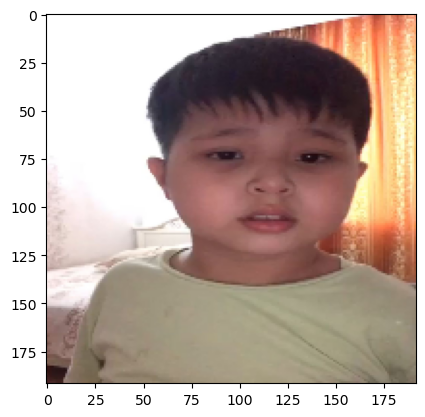

1/1 [==============================] - 0s 44ms/step
Predicted class: Open
True class: Open


In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np

data_batch, labels_batch = next(train_generator)

random_index = random.randint(0, data_batch.shape[0]-1)
random_image = data_batch[random_index]
random_label = labels_batch[random_index]

plt.imshow(random_image)
plt.show()

predictions = model.predict(random_image[np.newaxis, :])
predicted_class = np.argmax(predictions)

print("Predicted class:", class_labels[predicted_class])
print("True class:", class_labels[np.argmax(random_label)])

In [19]:
from tensorflow.keras.models import load_model
model.save("eyes.h5")

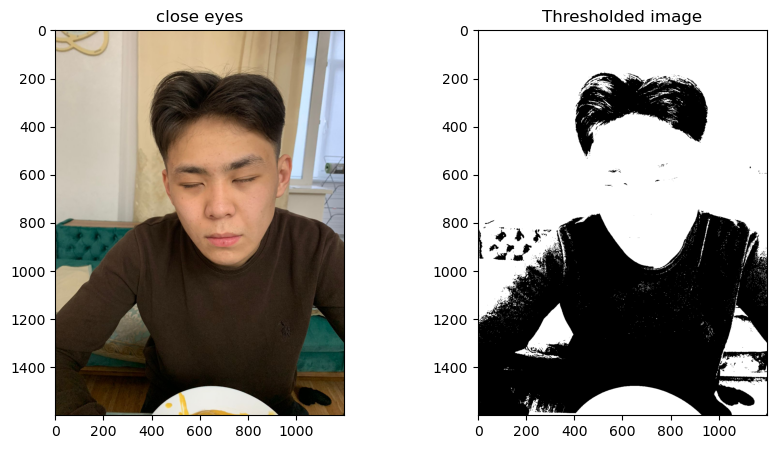

In [23]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

data_root = 'C:/Glaza'

train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')

class_labels = ['open', 'close']


class_name = random.choice(class_labels)
image_path = os.path.join(train_dir, class_name, random.choice(os.listdir(os.path.join(train_dir, class_name))))


img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title(class_name + ' eyes')
ax[1].imshow(thresh, cmap='gray')
ax[1].set_title('Thresholded image')
plt.show()

In [24]:
pip install playsound

In [25]:
from playsound import playsound
import os
file = "alarm.mp3"

In [26]:
import cv2
import numpy as np
import time

eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

cap = cv2.VideoCapture(0)


consecutive_closed_eyes = 0
last_alarm_time = time.time()


while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(eyes) == 0:
        prediction = 'eyes closed'
        area = 0
        consecutive_closed_eyes += 1
    else:
        for (x, y, w, h) in eyes:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            prediction = 'eyes open'

            ret, thresh = cv2.threshold(roi_gray, 50, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            contour_area_threshold = 500
            if len(contours) > 0:
                area = cv2.contourArea(contours[0])
                if area < contour_area_threshold:
                    prediction = 'eyes closed'
                    consecutive_closed_eyes += 1
            else:
                area = 0
                consecutive_closed_eyes += 1

    text = f"{prediction}, area: {area:.0f}"
    cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('frame', frame)

    if consecutive_closed_eyes >= 30:
        if time.time() - last_alarm_time >= 5:
            print("ALARM")
            os.system(file)
            last_alarm_time = time.time()

        consecutive_closed_eyes = 0

    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ALARM
